In [24]:
from IPython.display import Image
import torch
from torch import nn

## basics

- RoPE: rotary position embeddings
    - https://arxiv.org/pdf/2104.09864v4.pdf
        - ROFORMER, Jianlin Su
    - 属于 position embedding 的范畴
    - 通过旋转矩阵（rotation matrix）编码绝对位置信息
- 参考
    - https://blog.eleuther.ai/rotary-embeddings/
    - https://sh-tsang.medium.com/brief-review-roformer-enhanced-transformer-with-rotary-position-embedding-36f67a619442

- position encoding：位置编码核心要做的事情
    - token embedding $\mathbf x$, position $\ell$，其 position embedding 为
    $$
    f(\mathbf{x}, \ell)
    $$
    - 如另有两个 token embedding 分别为 $f(\mathbf q, m)$ 与 $f(\mathbf k, n)$，其 inner product 之后的结果应当只与 $m-n$ 有关（relative position）

- RoPE
    - 序列长度为 $N$，任取 $0\lt \varepsilon \lt \frac{2\pi}N$
    
$$
\begin{align}
\mathrm{RoPE}(x, m)&=xe^{mi\varepsilon}\\
\langle\mathrm{RoPE}(q_j, m), \mathrm{RoPE}(k_j, n)\rangle &=\langle q_je^{mi\varepsilon},k_je^{ni\varepsilon} \rangle \\
&=q_jk_j e^{mi\varepsilon} \overline{e^{ni\varepsilon}}\\
&=q_jk_je^{(m-n)i\varepsilon}\\
&=\mathrm{RoPE}(q_jk_j, m-n)
\end{align}
$$

## sin encoding

$$
\begin{split}
PE(t,2i)&=\sin(\frac{t}{10000^{\frac{2i}{d_{model}}}})\\
PE(t,2i+1)&=\cos(\frac{t}{10000^{\frac{2i}{d_{model}}}})\\
\Downarrow\\
PE(t,i)&=\sin(\frac{t}{10000^{\frac{i}{d_{model}}}}), \quad \text{i is even}\\
PE(t,i)&=\cos(\frac{t}{10000^{\frac{i-1}{d_{model}}}}), \quad \text{i is odd}\\
\end{split}
$$

In [1]:
max_sequence_length = 10
d_model = 6

In [6]:
even_i = torch.arange(0, d_model, 2).float()
print(even_i)
odd_i = torch.arange(1, d_model, 2).float()
print(odd_i)

tensor([0., 2., 4.])
tensor([1., 3., 5.])


In [9]:
position = torch.arange(max_sequence_length, dtype=torch.float).reshape(-1, 1)
position

tensor([[0.],
        [1.],
        [2.],
        [3.],
        [4.],
        [5.],
        [6.],
        [7.],
        [8.],
        [9.]])

In [19]:
even_pe = torch.sin(position / torch.pow(10000, even_i/d_model))
odd_pe = torch.cos(position / torch.pow(10000, (odd_i - 1)/d_model))

In [20]:
even_pe

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.8415,  0.0464,  0.0022],
        [ 0.9093,  0.0927,  0.0043],
        [ 0.1411,  0.1388,  0.0065],
        [-0.7568,  0.1846,  0.0086],
        [-0.9589,  0.2300,  0.0108],
        [-0.2794,  0.2749,  0.0129],
        [ 0.6570,  0.3192,  0.0151],
        [ 0.9894,  0.3629,  0.0172],
        [ 0.4121,  0.4057,  0.0194]])

In [21]:
odd_pe

tensor([[ 1.0000,  1.0000,  1.0000],
        [ 0.5403,  0.9989,  1.0000],
        [-0.4161,  0.9957,  1.0000],
        [-0.9900,  0.9903,  1.0000],
        [-0.6536,  0.9828,  1.0000],
        [ 0.2837,  0.9732,  0.9999],
        [ 0.9602,  0.9615,  0.9999],
        [ 0.7539,  0.9477,  0.9999],
        [-0.1455,  0.9318,  0.9999],
        [-0.9111,  0.9140,  0.9998]])

In [22]:
stacked = torch.stack([even_pe, odd_pe], dim=2)
stacked.shape

torch.Size([10, 3, 2])

In [23]:
torch.flatten(stacked, start_dim=1, end_dim=2)

tensor([[ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000],
        [ 0.8415,  0.5403,  0.0464,  0.9989,  0.0022,  1.0000],
        [ 0.9093, -0.4161,  0.0927,  0.9957,  0.0043,  1.0000],
        [ 0.1411, -0.9900,  0.1388,  0.9903,  0.0065,  1.0000],
        [-0.7568, -0.6536,  0.1846,  0.9828,  0.0086,  1.0000],
        [-0.9589,  0.2837,  0.2300,  0.9732,  0.0108,  0.9999],
        [-0.2794,  0.9602,  0.2749,  0.9615,  0.0129,  0.9999],
        [ 0.6570,  0.7539,  0.3192,  0.9477,  0.0151,  0.9999],
        [ 0.9894, -0.1455,  0.3629,  0.9318,  0.0172,  0.9999],
        [ 0.4121, -0.9111,  0.4057,  0.9140,  0.0194,  0.9998]])

In [25]:
class SinPositionEncoding(nn.Module):
    def __init__(self, max_sequence_length, d_model, base=10000):
        super().__init__()
        self.max_sequence_length = max_sequence_length
        self.d_model = d_model
        self.base = base
    def forward(self):
        even_i = torch.arange(0, self.d_model, 2).float()
        odd_i = torch.arange(1, self.d_model, 2).float()
        position = torch.arange(self.max_sequence_length, dtype=torch.float).reshape(-1, 1)
        even_pe = torch.sin(position / torch.pow(self.base, even_i/self.d_model))
        odd_pe = torch.cos(position / torch.pow(self.base, (odd_i-1)/self.d_model))
        stacked = torch.stack([even_pe, odd_pe], dim=2)
        return torch.flatten(stacked, start_dim=1, end_dim=2)

In [26]:
spe = SinPositionEncoding(max_sequence_length=10, d_model=6)
spe()

tensor([[ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000],
        [ 0.8415,  0.5403,  0.0464,  0.9989,  0.0022,  1.0000],
        [ 0.9093, -0.4161,  0.0927,  0.9957,  0.0043,  1.0000],
        [ 0.1411, -0.9900,  0.1388,  0.9903,  0.0065,  1.0000],
        [-0.7568, -0.6536,  0.1846,  0.9828,  0.0086,  1.0000],
        [-0.9589,  0.2837,  0.2300,  0.9732,  0.0108,  0.9999],
        [-0.2794,  0.9602,  0.2749,  0.9615,  0.0129,  0.9999],
        [ 0.6570,  0.7539,  0.3192,  0.9477,  0.0151,  0.9999],
        [ 0.9894, -0.1455,  0.3629,  0.9318,  0.0172,  0.9999],
        [ 0.4121, -0.9111,  0.4057,  0.9140,  0.0194,  0.9998]])

## RoPE

- 2d rotation matrix

$$
\begin{pmatrix}
\cos(m\theta), -\sin(m\theta)\\
\sin(m\theta), \cos(m\theta)
\end{pmatrix}
$$

- 如下将 2d $\mathbf x$ 旋转 $m\theta$（$\theta$ 表示刻度，）
    - 这里将 query 和 key 已经 position encoding 组装在一起

$$
f_{\{q,k\}}(\mathbf x, m)=\begin{pmatrix}
\cos(m\theta), -\sin(m\theta)\\
\sin(m\theta), \cos(m\theta)
\end{pmatrix}\begin{pmatrix}
W^{(11)}_{q,k},W^{(12)}_{q,k}\\
W^{(21)}_{q,k},W^{(22)}_{q,k}
\end{pmatrix}\begin{pmatrix}
x_{m}^{(1)}\\
x_{m}^{(2)}
\end{pmatrix}
$$

- 一个 general 的版本

$$
f_{\{q,k\}}(\mathbf x_m, m)=R^{d}_{\Theta, m}W_{q,k}x_m
$$

- 其中 $R^{d}_{\Theta,m}\in \mathbb R^{d\times d}$ 定义为：

$$
R^{d}_{\Theta,m}=\begin{pmatrix}
\cos(m\theta_1)& -\sin(m\theta_1)& 0 & 0 & \cdots & 0 & 0\\
\sin(m\theta_1)&  \cos(m\theta_1)& 0 & 0 & \cdots & 0 & 0\\
0 & 0 & \cos(m\theta_2)& -\sin(m\theta_2)& \cdots & 0 & 0\\
0 & 0 & \sin(m\theta_2)&  \cos(m\theta_2)& \cdots & 0 & 0\\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\
0 & 0 & 0 & 0 & \cdots & \cos(m\theta_{d/2})& -\sin(m\theta_{d/2}) \\
0 & 0 & 0 & 0 & \cdots & \sin(m\theta_{d/2})& \cos(m\theta_{d/2})
\end{pmatrix}
$$

- $R^{d}_{\Theta,m}\mathbf x$ 的一种高效形式

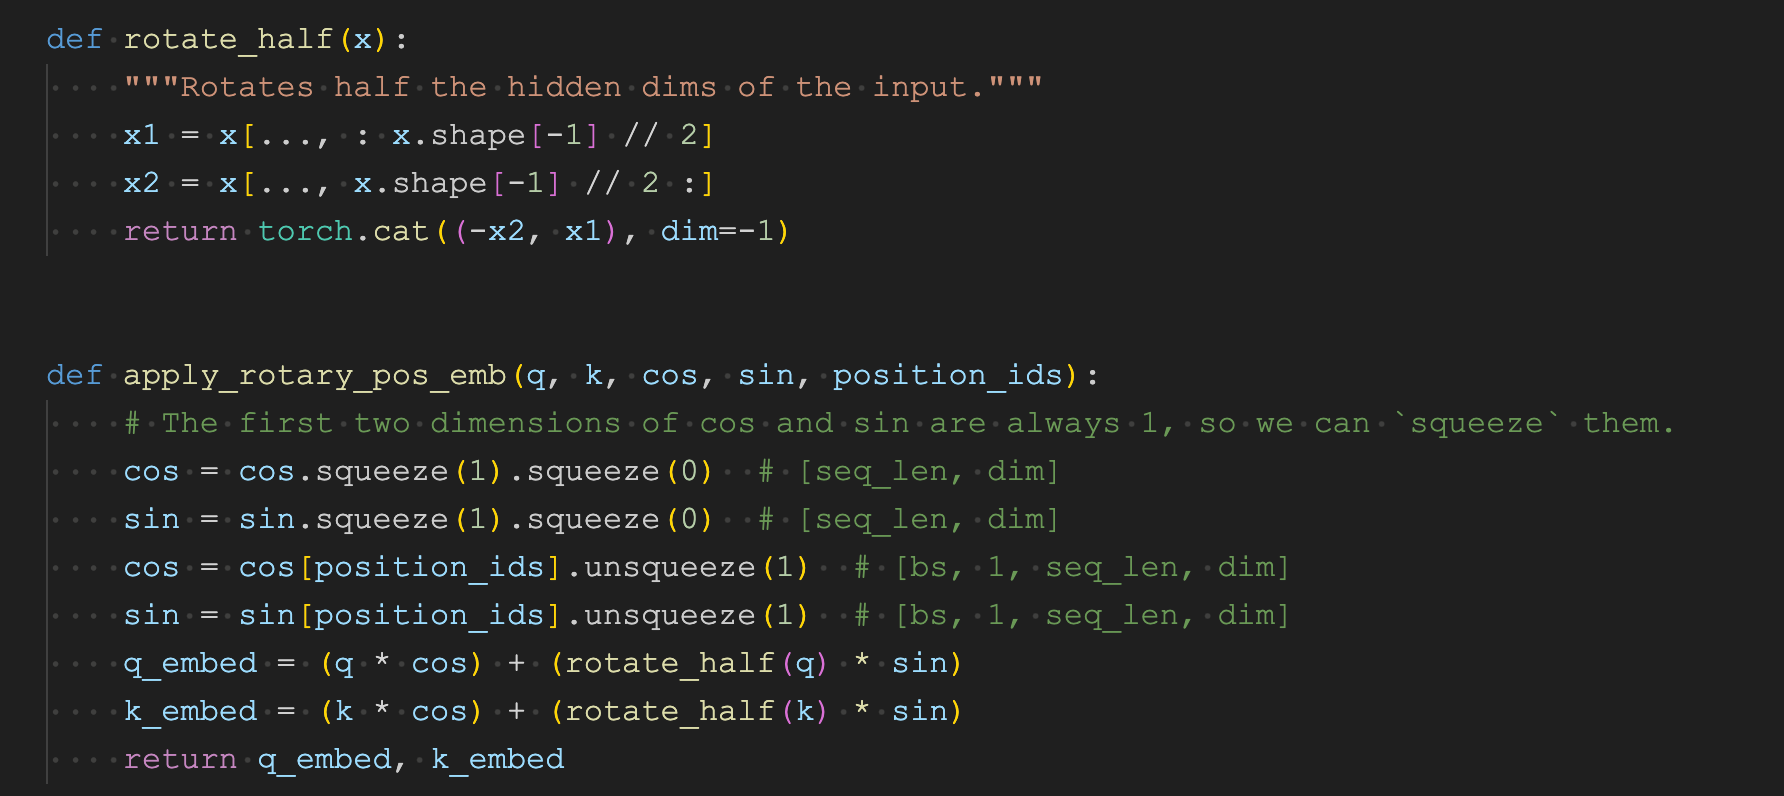

In [22]:
Image('../imgs/hf_llama_rope.png', width=600)

### precompute_freqs_cis

```
def precompute_freqs_cis(dim: int, end: int, theta: float = 10000.0):
    freqs = 1.0 / (theta ** (torch.arange(0, dim, 2)[: (dim // 2)].float() / dim))
    t = torch.arange(end, device=freqs.device)  # type: ignore
    freqs = torch.outer(t, freqs).float()  # type: ignore
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)  # complex64
    return freqs_cis
```

$$
\begin{split}
&\text{freqs} = \frac1{10000^{2i}}\quad &\in \mathbb R^{dim/2=64}\\
&t=0,1,2,\cdots,2\times\text{max_seq_len}\quad &\in \mathbb R^{2*\text{max_seq_len}=2048}\\
&\text{freqs} \in \mathbb R ^{2048\times 64}
\end{split}
$$

- freqs: 行表示position，列表示 dim
- `torch.polar(abs, angle)`
    - $\text{out} = \text{abs} \cdot \cos(\text{angle}) + \text{abs} \cdot \sin(\text{angle}) \cdot j$
    - 实部是 `cos`，虚部是 `sin`，压缩了一倍的存储
    
    - 关于复数及复数乘法
    
    $$
    \begin{split}
    &(a+bi)(c+di)=(ac-bd)+(bc+ad)i\\
    &(\cos\theta_1+\sin\theta_1i)(\cos\theta_2+\sin\theta_2i)=(\cos\theta_1\cos\theta_2-\sin\theta_1\sin\theta_2)+(\sin\theta_1\cos\theta_2+\cos\theta_1\sin\theta_2)i
    \end{split}
    $$
    
- llama2-7b
    - dim: 4096, head: 32
    - precompute_freqs_cis: 
        - dim: 4096/32 = 128, 每一个head的dim
        - end：1024\*2 = 2048，1024: max seq len
        - freq_cis.shape
            - (1024\*2) \* (128/2): 2048 \* 64

In [23]:
import torch

In [37]:
def precompute_freqs_cis(dim: int, end: int, theta: float = 10000.0):
    freqs = 1.0 / (theta ** (torch.arange(0, dim, 2)[: (dim // 2)].float() / dim))
    t = torch.arange(end)  # type: ignore
    freqs = torch.outer(t, freqs).float()  # type: ignore
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)  # complex64
    return freqs_cis


In [48]:
dim, end = 6, 5
freqs_cis = precompute_freqs_cis(dim, end)
freqs_cis

tensor([[ 1.0000+0.0000j,  1.0000+0.0000j,  1.0000+0.0000j],
        [ 0.5403+0.8415j,  0.9989+0.0464j,  1.0000+0.0022j],
        [-0.4161+0.9093j,  0.9957+0.0927j,  1.0000+0.0043j],
        [-0.9900+0.1411j,  0.9903+0.1388j,  1.0000+0.0065j],
        [-0.6536-0.7568j,  0.9828+0.1846j,  1.0000+0.0086j]])

In [49]:
theta = 10000
my_freqs_cis = torch.outer(torch.arange(end), 1./(theta ** (torch.arange(0, 6, 2))))
complex_tensor = torch.polar(torch.ones_like(my_freqs_cis), my_freqs_cis)
complex_tensor

tensor([[ 1.0000+0.0000e+00j,  1.0000+0.0000e+00j,  1.0000+0.0000e+00j],
        [ 0.5403+8.4147e-01j,  1.0000+1.0000e-08j,  1.0000+1.0000e-16j],
        [-0.4161+9.0930e-01j,  1.0000+2.0000e-08j,  1.0000+2.0000e-16j],
        [-0.9900+1.4112e-01j,  1.0000+3.0000e-08j,  1.0000+3.0000e-16j],
        [-0.6536-7.5680e-01j,  1.0000+4.0000e-08j,  1.0000+4.0000e-16j]])

In [50]:
complex_tensor.shape

torch.Size([5, 3])

In [51]:
torch.view_as_real(complex_tensor)

tensor([[[ 1.0000e+00,  0.0000e+00],
         [ 1.0000e+00,  0.0000e+00],
         [ 1.0000e+00,  0.0000e+00]],

        [[ 5.4030e-01,  8.4147e-01],
         [ 1.0000e+00,  1.0000e-08],
         [ 1.0000e+00,  1.0000e-16]],

        [[-4.1615e-01,  9.0930e-01],
         [ 1.0000e+00,  2.0000e-08],
         [ 1.0000e+00,  2.0000e-16]],

        [[-9.8999e-01,  1.4112e-01],
         [ 1.0000e+00,  3.0000e-08],
         [ 1.0000e+00,  3.0000e-16]],

        [[-6.5364e-01, -7.5680e-01],
         [ 1.0000e+00,  4.0000e-08],
         [ 1.0000e+00,  4.0000e-16]]])